In [1]:
# Install helpers
!pip install --quiet gdown
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

In [2]:
from pathlib import Path
import gdown

DATA_DIR = Path("data")
CSV_DIR = Path("csv_files")
OUT_DIR = Path("outputs")

DATA_DIR.mkdir(exist_ok=True)
CSV_DIR.mkdir(exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)
trader_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"       # historical trader
fg_id = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"           # Fear/Greed index

trader_path = DATA_DIR / "trader.csv"
fg_path = DATA_DIR / "fear_greed.csv"

if not trader_path.exists():
    gdown.download(id=trader_id, output=str(trader_path), quiet=False)

if not fg_path.exists():
    gdown.download(id=fg_id, output=str(fg_path), quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/data/trader.csv
100%|██████████| 47.5M/47.5M [00:01<00:00, 29.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/data/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 58.5MB/s]


In [3]:
trader = pd.read_csv(trader_path, low_memory=False)
fg_raw = pd.read_csv(fg_path, low_memory=False)
print(trader.columns.tolist())
print(fg_raw.columns.tolist())

['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
['timestamp', 'value', 'classification', 'date']


In [4]:
import pandas as pd

fg = fg_raw.copy()

fg['date'] = pd.to_datetime(fg['date'], errors='coerce').dt.normalize()

fg['sentiment'] = fg['classification'].astype(str).str.strip().str.title()

fg_clean = fg[['date', 'sentiment', 'value']].dropna()

fg_clean.head()

,date,sentiment,value
0,2018-02-01,Fear,30
1,2018-02-02,Extreme Fear,15
2,2018-02-03,Fear,40
3,2018-02-04,Extreme Fear,24
4,2018-02-05,Extreme Fear,11


In [5]:
tr = trader.copy()

tr['time_parsed'] = pd.to_datetime(tr['Timestamp IST'], errors='coerce')

tr['date'] = tr['time_parsed'].dt.normalize()


numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee']

for col in numeric_cols:
    if col in tr.columns:
        tr[col] = pd.to_numeric(tr[col], errors='coerce')


if 'Side' in tr.columns:
    tr['Side'] = tr['Side'].astype(str).str.strip().str.lower()

if 'Direction' in tr.columns:
    tr['Direction'] = tr['Direction'].astype(str).str.strip().str.lower()

if 'Coin' in tr.columns:
    tr['Coin'] = tr['Coin'].astype(str).str.strip()

print("Trader rows:", len(tr))
print(tr[['Timestamp IST', 'time_parsed', 'date']].head())

Trader rows: 211224
      Timestamp IST         time_parsed       date
0  02-12-2024 22:50 2024-02-12 22:50:00 2024-02-12
1  02-12-2024 22:50 2024-02-12 22:50:00 2024-02-12
2  02-12-2024 22:50 2024-02-12 22:50:00 2024-02-12
3  02-12-2024 22:50 2024-02-12 22:50:00 2024-02-12
4  02-12-2024 22:50 2024-02-12 22:50:00 2024-02-12


In [6]:
merged = tr.merge(
    fg_clean,
    on='date',
    how='left',
    validate='m:1'
)

print("Merged shape:", merged.shape)
merged.head(10)

Merged shape: (211224, 20)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time_parsed,date,sentiment,value
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,02-12-2024 22:50,0.000000,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,02-12-2024 22:50,986.524596,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,02-12-2024 22:50,1002.518996,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,02-12-2024 22:50,1146.558564,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,02-12-2024 22:50,1289.488521,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9900,1.41,11.27,buy,02-12-2024 22:50,1298.215466,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.000493,7.330000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9934,144.09,1151.77,buy,02-12-2024 22:50,1299.624972,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,9.060000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,34.00,272.00,buy,02-12-2024 22:50,1443.664541,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.011900,3.960000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
8,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,46.00,368.00,buy,02-12-2024 22:50,1477.652641,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.016100,9.460000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0
9,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,12.50,100.00,buy,02-12-2024 22:50,1523.636541,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.004375,3.470000e+13,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70.0


Total trades: 211224
Total closed PnL: 10296958.94
Mean closed PnL: 48.75, Median closed PnL: 0.00
Overall win rate: 41.13%

By sentiment:
        sentiment  trades_count     total_pnl    mean_pnl  median_pnl  \
2           Fear         13869  1.779226e+06  128.287950     0.00000   
3          Greed         11292  6.096325e+05   53.988003     0.00000   
1  Extreme Greed          5621  1.156894e+06  205.816345     0.96048   
4        Neutral          2756  7.465674e+04   27.088803     0.00000   
0   Extreme Fear          2326  4.399937e+03    1.891632     0.00000   

   win_rate  avg_size_usd   avg_fee  
2  0.381787   5744.782685  1.131521  
3  0.435707   5051.878829  1.092947  
1  0.553282   3242.085086  0.835794  
4  0.494920   4332.202906  0.922389  
0  0.292777   4118.761840  0.686479  

Top 10 coins by trade count:
           Coin  trades_count     total_pnl    mean_pnl  win_rate  avg_size_usd
137       HYPE         68005  1.948485e+06   28.652079  0.414999   2087.937741
4         

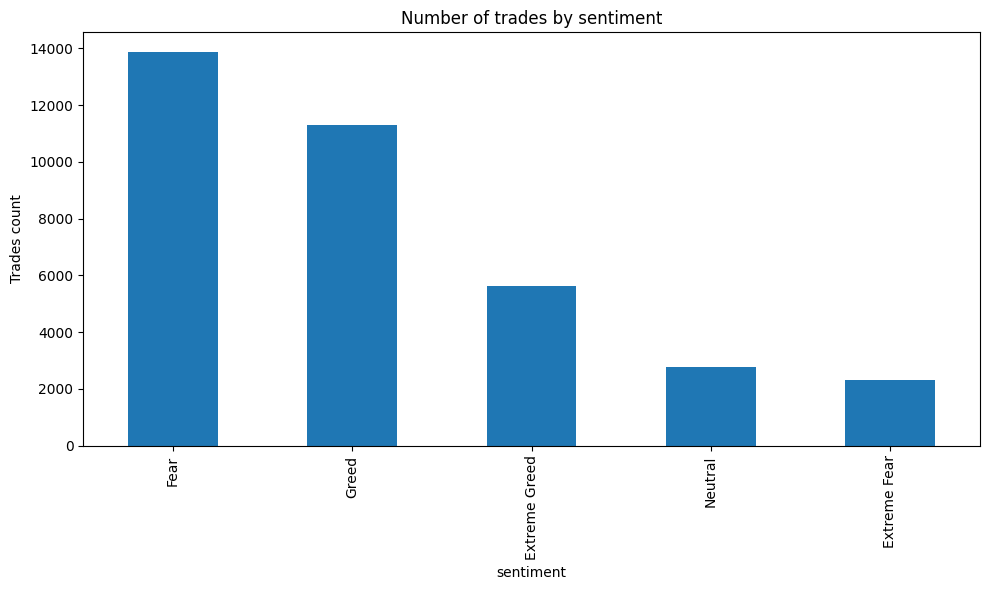

Saved: outputs/mean_pnl_by_sentiment.png


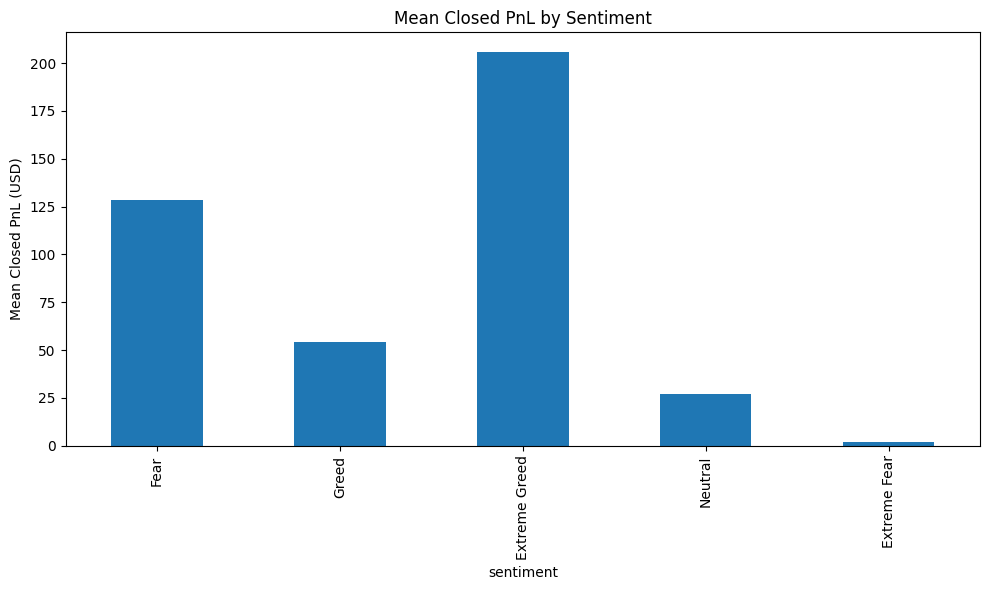

/tmp/ipython-input-1161332386.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=agg_sent['sentiment'], showfliers=False)


Saved: outputs/pnl_box_by_sentiment.png


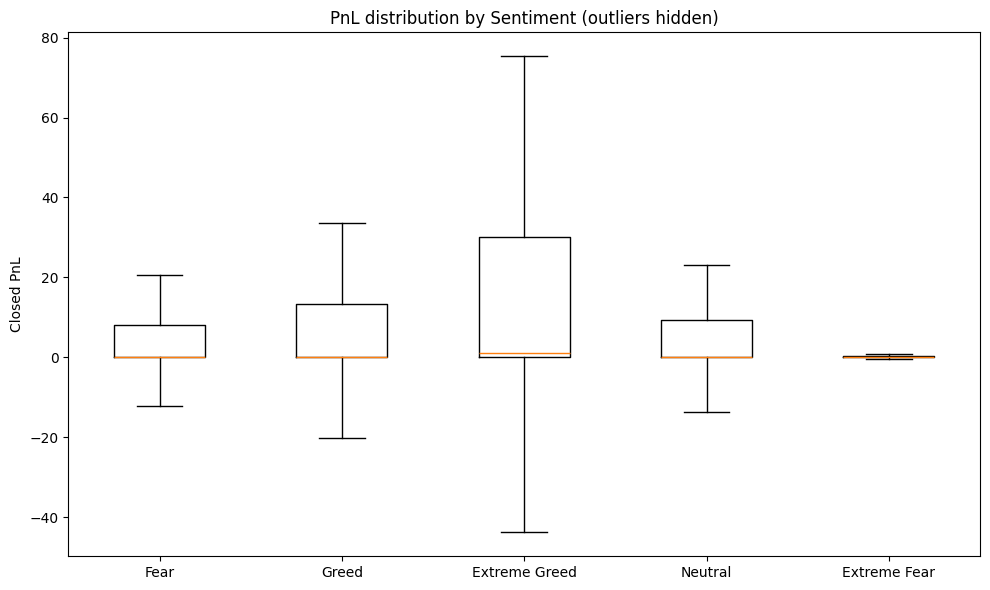

Saved: outputs/top_coins_total_pnl.png


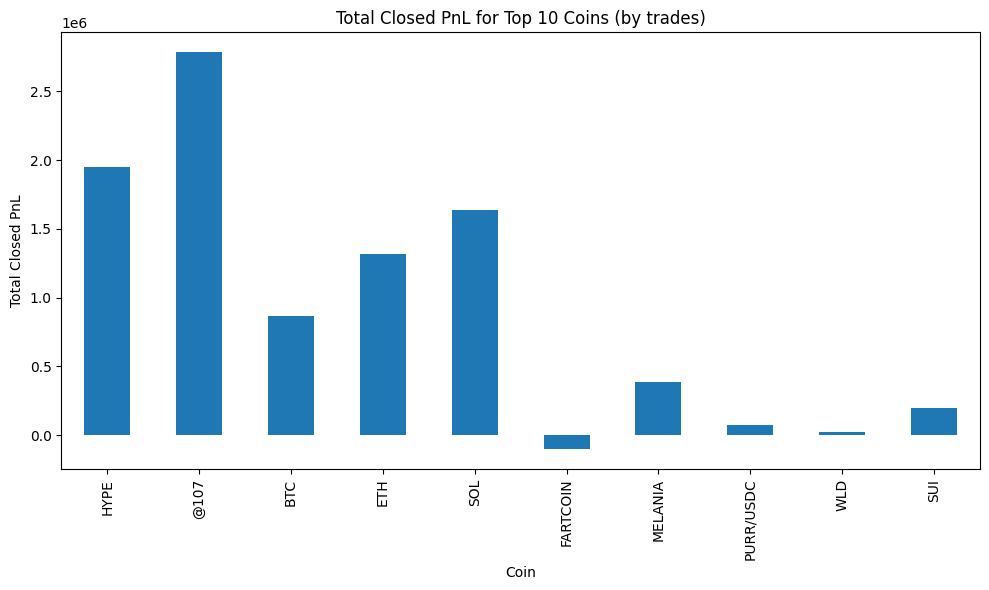

Saved: outputs/win_rate_by_sentiment.png


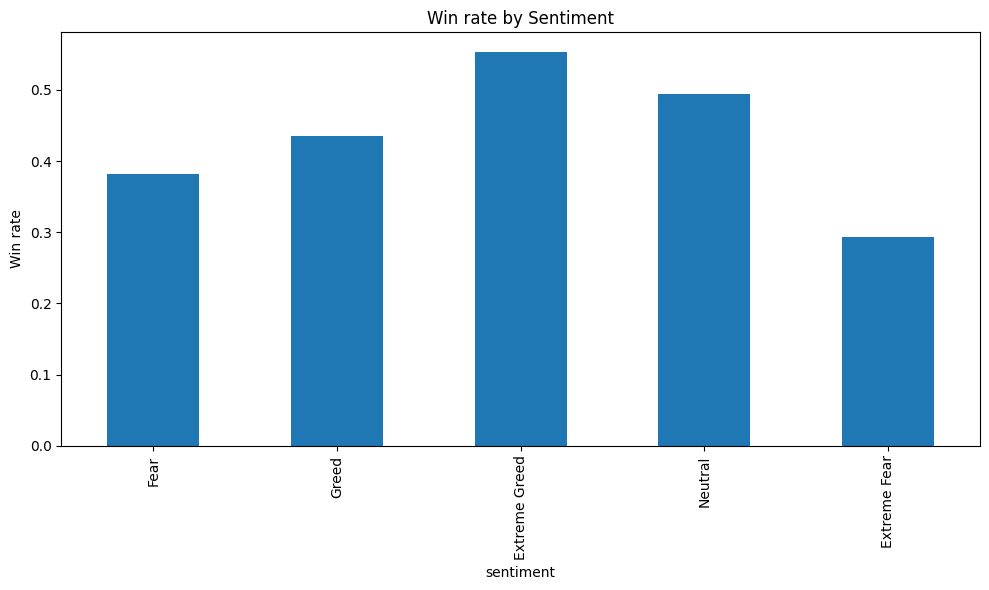

Saved: outputs/trades_by_hour.png


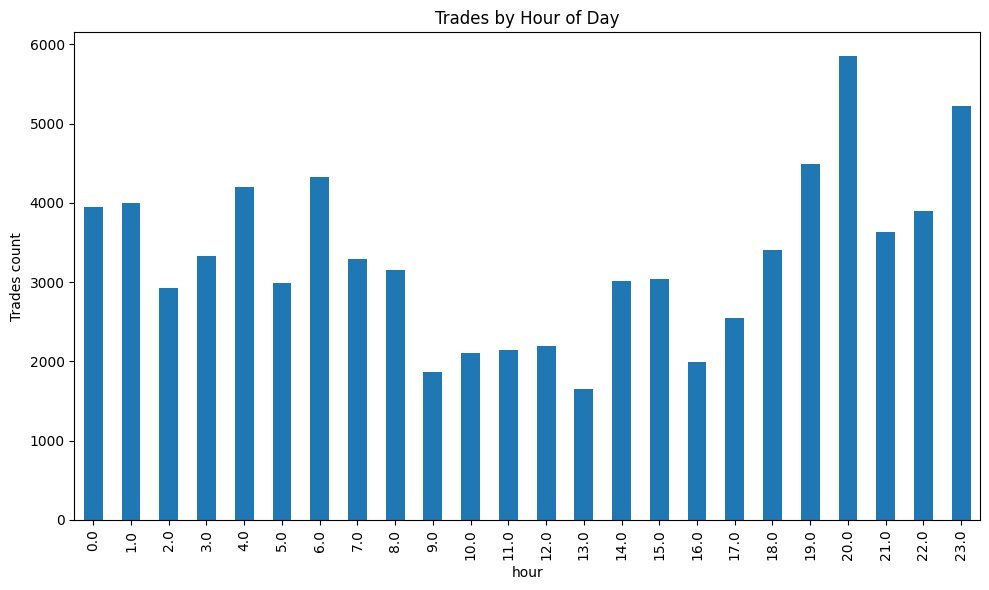

Saved: outputs/mean_pnl_by_hour.png


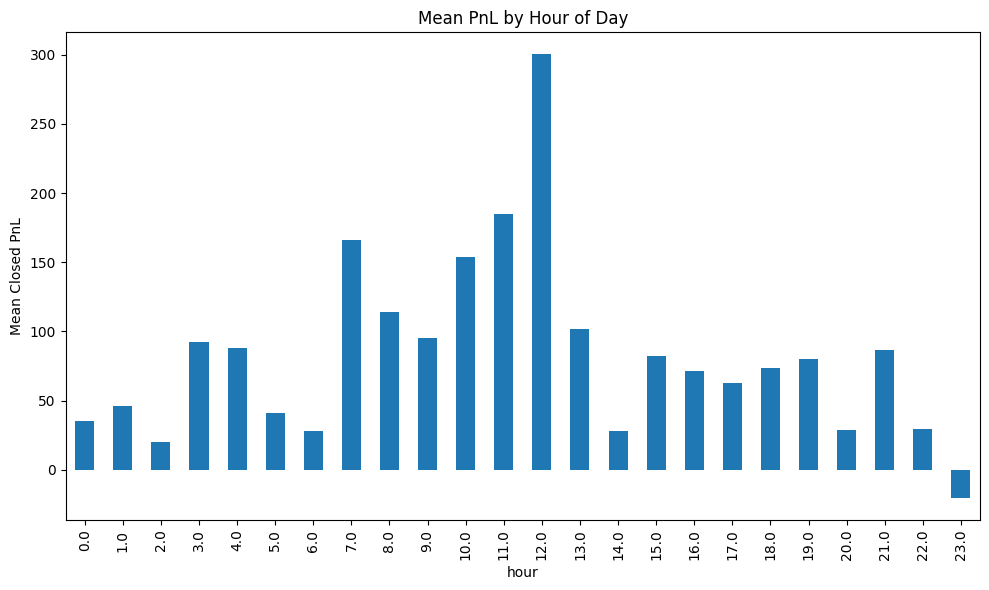

Saved: outputs/fee_vs_size_scatter.png


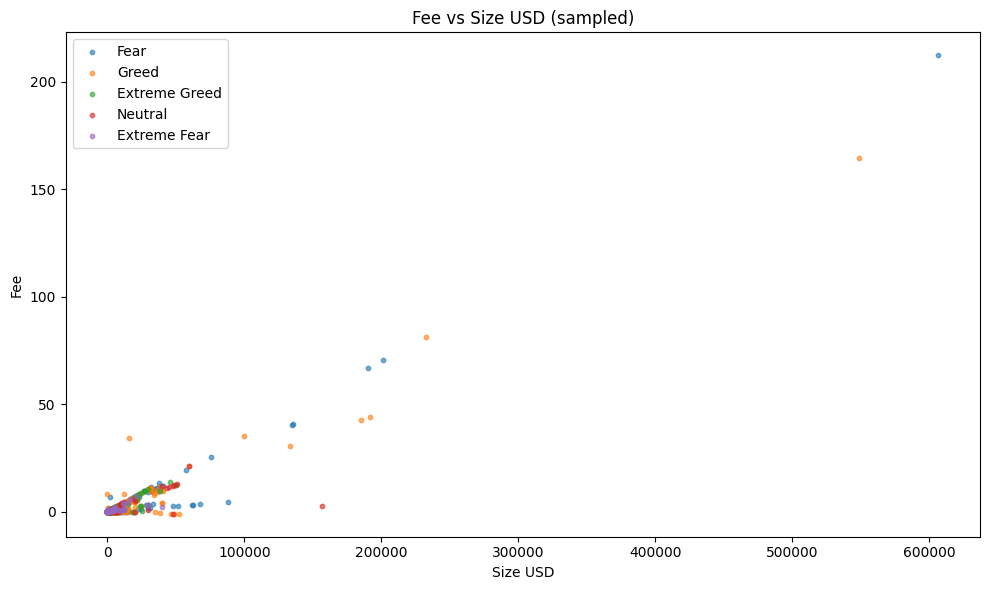

Saved: outputs/pnl_histogram.png


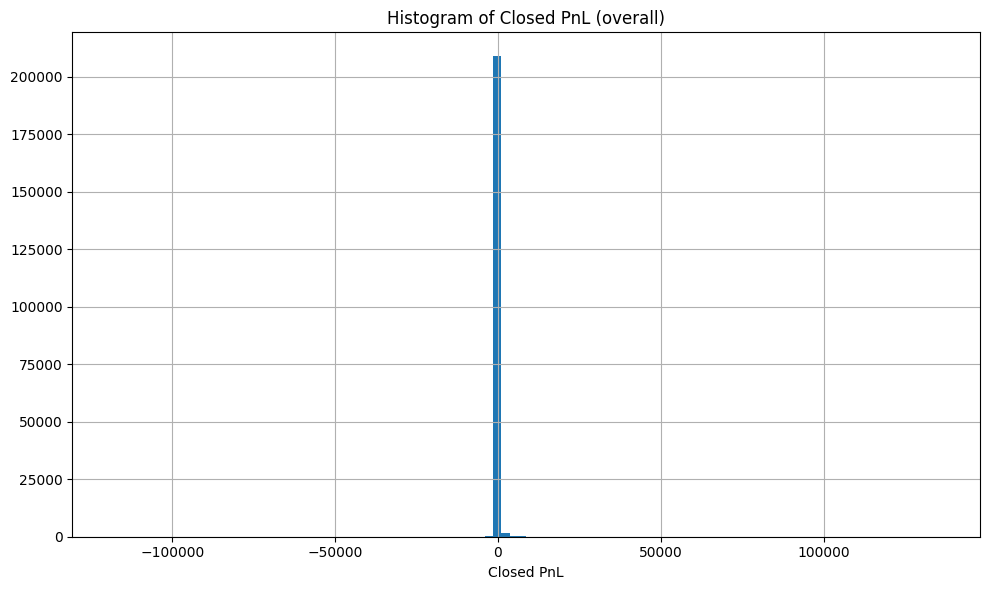


Saved sample merged and aggregations to csv_files/ and charts to outputs/


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

CSV_DIR = Path("csv_files")
OUT_DIR = Path("outputs")
CSV_DIR.mkdir(exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

df = merged.copy()

df['Closed PnL'] = pd.to_numeric(df['Closed PnL'], errors='coerce')
if 'Size USD' in df.columns:
    df['Size USD'] = pd.to_numeric(df['Size USD'], errors='coerce')
if 'Fee' in df.columns:
    df['Fee'] = pd.to_numeric(df['Fee'], errors='coerce')

total_trades = len(df)
total_pnl = df['Closed PnL'].sum(skipna=True)
median_pnl = df['Closed PnL'].median(skipna=True)
mean_pnl = df['Closed PnL'].mean(skipna=True)
win_rate_overall = (df['Closed PnL'] > 0).mean()  # fraction

print(f"Total trades: {total_trades}")
print(f"Total closed PnL: {total_pnl:.2f}")
print(f"Mean closed PnL: {mean_pnl:.2f}, Median closed PnL: {median_pnl:.2f}")
print(f"Overall win rate: {win_rate_overall:.2%}")

agg_sent = df.groupby('sentiment').agg(
    trades_count=('Account','count'),
    total_pnl=('Closed PnL','sum'),
    mean_pnl=('Closed PnL','mean'),
    median_pnl=('Closed PnL','median'),
    win_rate=('Closed PnL', lambda x: (x>0).mean()),
    avg_size_usd=('Size USD','mean'),
    avg_fee=('Fee','mean')
).reset_index().sort_values('trades_count', ascending=False)

print("\nBy sentiment:\n", agg_sent)
agg_sent.to_csv(CSV_DIR / "agg_by_sentiment.csv", index=False)

agg_coin = df.groupby('Coin').agg(
    trades_count=('Account','count'),
    total_pnl=('Closed PnL','sum'),
    mean_pnl=('Closed PnL','mean'),
    win_rate=('Closed PnL', lambda x: (x>0).mean()),
    avg_size_usd=('Size USD','mean')
).reset_index().sort_values('trades_count', ascending=False)

print("\nTop 10 coins by trade count:\n", agg_coin.head(10))
agg_coin.to_csv(CSV_DIR / "agg_by_coin.csv", index=False)

if 'Direction' in df.columns:
    agg_dir = df.groupby('Direction').agg(
        trades_count=('Account','count'),
        total_pnl=('Closed PnL','sum'),
        mean_pnl=('Closed PnL','mean'),
        win_rate=('Closed PnL', lambda x: (x>0).mean()),
        avg_size_usd=('Size USD','mean')
    ).reset_index()
    print("\nBy Direction:\n", agg_dir)
    agg_dir.to_csv(CSV_DIR / "agg_by_direction.csv", index=False)
else:
    print("\nNo 'Direction' column found for direction-level aggregation.")

agg_account = df.groupby('Account').agg(
    trades_count=('Account','count'),
    total_pnl=('Closed PnL','sum'),
    mean_pnl=('Closed PnL','mean'),
    win_rate=('Closed PnL', lambda x: (x>0).mean()),
    avg_size_usd=('Size USD','mean')
).reset_index().sort_values('total_pnl', ascending=False)

agg_account.head(20).to_csv(CSV_DIR / "top_accounts.csv", index=False)
print("\nTop 10 accounts by total pnl:\n", agg_account.head(10))

if 'time_parsed' in df.columns:
    df['hour'] = df['time_parsed'].dt.hour
    agg_hour = df.groupby('hour').agg(
        trades_count=('Account','count'),
        total_pnl=('Closed PnL','sum'),
        mean_pnl=('Closed PnL','mean'),
        win_rate=('Closed PnL', lambda x: (x>0).mean())
    ).reset_index()
    agg_hour.to_csv(CSV_DIR / "agg_by_hour.csv", index=False)
    print("\nTrades by hour (sample):\n", agg_hour.head(24))
else:
    print("\nNo 'time_parsed' column found for hour-of-day analysis.")

if 'date' in df.columns:
    daily = df.groupby('date').agg(
        trades_count=('Account','count'),
        total_pnl=('Closed PnL','sum'),
        mean_pnl=('Closed PnL','mean')
    ).reset_index().sort_values('date')
    daily.to_csv(CSV_DIR / "daily_pnl.csv", index=False)
    print("\nDaily sample:\n", daily.head())
else:
    print("\nNo 'date' column found for daily aggregation.")

# VISUALIZATIONS
def save_fig(fig, fname):
    path = OUT_DIR / fname
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    print("Saved:", path)

fig, ax = plt.subplots()
agg_sent.plot(kind='bar', x='sentiment', y='trades_count', legend=False, ax=ax)
ax.set_title("Number of trades by sentiment")
ax.set_ylabel("Trades count")
save_fig(fig, "trades_by_sentiment.png")
plt.show()

fig, ax = plt.subplots()
agg_sent.plot(kind='bar', x='sentiment', y='mean_pnl', legend=False, ax=ax)
ax.set_title("Mean Closed PnL by Sentiment")
ax.set_ylabel("Mean Closed PnL (USD)")
save_fig(fig, "mean_pnl_by_sentiment.png")
plt.show()

fig, ax = plt.subplots()
box_data = [df.loc[df['sentiment'] == s, 'Closed PnL'].dropna() for s in agg_sent['sentiment']]
ax.boxplot(box_data, labels=agg_sent['sentiment'], showfliers=False)
ax.set_title("PnL distribution by Sentiment (outliers hidden)")
ax.set_ylabel("Closed PnL")
save_fig(fig, "pnl_box_by_sentiment.png")
plt.show()

top_coins = agg_coin.head(10).copy()
fig, ax = plt.subplots()
top_coins.plot(kind='bar', x='Coin', y='total_pnl', legend=False, ax=ax)
ax.set_title("Total Closed PnL for Top 10 Coins (by trades)")
ax.set_ylabel("Total Closed PnL")
save_fig(fig, "top_coins_total_pnl.png")
plt.show()

fig, ax = plt.subplots()
agg_sent.plot(kind='bar', x='sentiment', y='win_rate', legend=False, ax=ax)
ax.set_title("Win rate by Sentiment")
ax.set_ylabel("Win rate")
save_fig(fig, "win_rate_by_sentiment.png")
plt.show()

if 'hour' in df.columns:
    fig, ax = plt.subplots()
    agg_hour.plot(kind='bar', x='hour', y='trades_count', legend=False, ax=ax)
    ax.set_title("Trades by Hour of Day")
    ax.set_ylabel("Trades count")
    save_fig(fig, "trades_by_hour.png")
    plt.show()

    fig, ax = plt.subplots()
    agg_hour.plot(kind='bar', x='hour', y='mean_pnl', legend=False, ax=ax)
    ax.set_title("Mean PnL by Hour of Day")
    ax.set_ylabel("Mean Closed PnL")
    save_fig(fig, "mean_pnl_by_hour.png")
    plt.show()

if 'Fee' in df.columns and 'Size USD' in df.columns:
    small = df.dropna(subset=['Fee','Size USD','sentiment']).sample(n=min(2000, len(df)))
    fig, ax = plt.subplots()
    for s in small['sentiment'].unique():
        sub = small[small['sentiment']==s]
        ax.scatter(sub['Size USD'], sub['Fee'], alpha=0.6, label=str(s), s=10)
    ax.set_xlabel("Size USD")
    ax.set_ylabel("Fee")
    ax.set_title("Fee vs Size USD (sampled)")
    ax.legend()
    save_fig(fig, "fee_vs_size_scatter.png")
    plt.show()

fig, ax = plt.subplots()
df['Closed PnL'].dropna().hist(bins=100, ax=ax)
ax.set_title("Histogram of Closed PnL (overall)")
ax.set_xlabel("Closed PnL")
save_fig(fig, "pnl_histogram.png")
plt.show()

df.sample(min(2000, len(df))).to_csv(CSV_DIR / "merged_sample.csv", index=False)
print("\nSaved sample merged and aggregations to csv_files/ and charts to outputs/")